In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor,Normalize, Resize,ToPILImage,RandomAffine
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import inspect
import time
import os

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
import pandas as pd
import pickle
import os.path
import sys

#This is a workaround for reading in pickle files, the data was too large for one of us and threw an error
# if read in normally. 
# Code taken from https://stackoverflow.com/questions/42653386/does-pickle-randomly-fail-with-oserror-on-large-files/42725930. 
def try_to_load_as_pickled_object_or_None(filepath):
    """
    This is a defensive way to write pickle.load, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inputting Data


In [0]:

images = try_to_load_as_pickled_object_or_None('drive/My Drive/train_max_x') 
number_train_images = int(images.shape[0] * .9) #Will be used to split training and validation vectors 
print(number_train_images)
labels = pd.read_csv('drive/My Drive/train_max_y.csv') # train_labels
test_images = pd.read_pickle('drive/My Drive/test_max_x')

images = images[:number_train_images]
print(images.shape)

train_images,val_images,train_labels, val_labels = train_test_split(images, labels['Label'][:number_train_images].values, test_size=0.0005, random_state=42)
labels = labels['Label'][:].values
test_labels = np.empty([test_images.shape[0],])

X_validation = images[number_train_images:]



45000
(45000, 128, 128)


In [0]:
from torchvision.models.resnet import ResNet, BasicBlock

#Architecture for adapting the ResNet18 model for a MNIST use case
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(
            super(MnistResNet, self).forward(x), dim=-1)

In [0]:
from torch.utils.data.dataset import Dataset

#Class that is used to perform standardization across different loaders
# when called in function below (get_data_loaders)
class ModMNISTDataset(Dataset):
    def __init__(self,images,labels,transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, index):
        # stuff
        img = self.images[index]
        
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[index]
            
        return (img, label)

    def __len__(self):
        count = self.images.shape[0]
        return count

In [0]:
#Called in training setup to establish transformations and batch sizes for each loader 
#Returns 3 different loaders: train, validation, test 
def get_data_loaders(train_batch_size, val_batch_size, test_batch_size):
        
    data_transform = Compose([ ToPILImage(),
                               Resize((224, 224)), #The standard input image size for ResNet
                               ToTensor(), 
                               Normalize((images.mean()/255,), (images.std()/255,))]) #Normalizing the data 

    train_loader = DataLoader(ModMNISTDataset(images,labels,data_transform),batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(ModMNISTDataset(images,labels,data_transform),batch_size=val_batch_size, shuffle=False)
    
    test_loader = DataLoader(ModMNISTDataset(test_images,test_labels,data_transform),batch_size=test_batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [0]:

#Training setup 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MnistResNet().to(device)

epochs = 25

#Runtime 
start_ts = time.time()

#Grab all the different loaders 
train_loader, val_loader, test_loader = get_data_loaders(32, 32, 1)

losses = [] #Will be used to show validation loss
acc2 = [] #Will be used to show validation accuracy
acc3 = [] 

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

#Start of training and evaluation loop
for epoch in range(0, epochs): #loop for all epochs (based on number above)
    total_loss = 0
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches) #Progress bar that keeps track of the batches trained in the train_loader
    
    #Start of training
    model.train()
    
    for i, data in progress:

        #Training of a single batch
        X, y = data[0].to(device), data[1].to(device)
        
        model.zero_grad()
        outputs = model(X)
        
        loss = loss_function(outputs, y)
        loss.backward()

        optimizer.step()

        #Calculate losses
        current_loss = loss.item()
        total_loss += current_loss
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1))) #Update  
        
    torch.cuda.empty_cache()
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], [] #Metrics we want to calculate 
    
    #Evaluation/testing loop
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            #Gets the prediction from the network
            outputs = model(X)

            val_loss = loss_function(outputs, y)
            val_losses += val_loss

            #Get class from network's prediction
            predicted_classes = torch.max(outputs, 1)[1]
            
            #Calculate the metrics
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
    #After each epoch, display the progress and metrics with methods above 
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)

    #Calc val acc for each epoch 
    total_scores = 0
    for scores in accuracy:
      total_scores = total_scores + scores 
    
    accAvg = total_scores / val_batches
    accAvg2 = total_scores / batches

    acc2.append(accAvg) #Append acc
    print(acc2[epoch])

    acc3.append(accAvg2)
    print(acc3[epoch])

    
print(losses)
print(f"Training time: {time.time()-start_ts}s") #Print runtime

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch 1/25, training loss: 2.149904502226091, validation loss: 2.189628839492798
	     precision: 0.1799
	        recall: 0.1934
	            F1: 0.1221
	      accuracy: 0.2662
0.2662135749822317
0.2662135749822317



Epoch 2/25, training loss: 1.9120603819306894, validation loss: 1.9179913997650146
	     precision: 0.2306
	        recall: 0.3357
	            F1: 0.2647
	      accuracy: 0.5415
0.5414889836531628
0.5414889836531628



Epoch 3/25, training loss: 1.802794616020734, validation loss: 1.7370725870132446
	     precision: 0.4941
	        recall: 0.5608
	            F1: 0.5051
	      accuracy: 0.7272
0.7271899431414357
0.7271899431414357



Epoch 4/25, training loss: 1.7076692116879026, validation loss: 1.891626238822937
	     precision: 0.4161
	        recall: 0.4283
	            F1: 0.3695
	      accuracy: 0.5674
0.5674307036247335
0.5674307036247335



Epoch 5/25, training loss: 1.6767276889818648, validation loss: 1.885377287864685
	     precision: 0.4629
	        recall: 0.4805
	            F1: 0.4068
	      accuracy: 0.5748
0.5747601279317697
0.5747601279317697



Epoch 6/25, training loss: 1.666706808170869, validation loss: 1.7691152095794678
	     precision: 0.4756
	        recall: 0.5513
	            F1: 0.4794
	      accuracy: 0.6908
0.6907871357498223
0.6907871357498223



Epoch 7/25, training loss: 1.6563314550212707, validation loss: 1.6397621631622314
	     precision: 0.5955
	        recall: 0.6411
	            F1: 0.5982
	      accuracy: 0.8205
0.8204957356076759
0.8204957356076759



Epoch 8/25, training loss: 1.6174534758355656, validation loss: 1.6109325885772705
	     precision: 0.6657
	        recall: 0.7195
	            F1: 0.6750
	      accuracy: 0.8507
0.8507240582800284
0.8507240582800284



Epoch 9/25, training loss: 1.592510501543681, validation loss: 1.7074615955352783
	     precision: 0.6093
	        recall: 0.6675
	            F1: 0.6027
	      accuracy: 0.7536
0.7535536602700782
0.7535536602700782



Epoch 10/25, training loss: 1.589332746205469, validation loss: 1.5750547647476196
	     precision: 0.7024
	        recall: 0.7528
	            F1: 0.7122
	      accuracy: 0.8861
0.8861496090973703
0.8861496090973703



Epoch 11/25, training loss: 1.5717844355589292, validation loss: 1.641783595085144
	     precision: 0.6934
	        recall: 0.6977
	            F1: 0.6662
	      accuracy: 0.8194
0.8194074271499645
0.8194074271499645



Epoch 12/25, training loss: 1.5473216874597762, validation loss: 1.5348845720291138
	     precision: 0.8085
	        recall: 0.8297
	            F1: 0.8088
	      accuracy: 0.9265
0.9264836531627576
0.9264836531627576



Epoch 13/25, training loss: 1.5417135046489203, validation loss: 1.5408562421798706
	     precision: 0.8020
	        recall: 0.8312
	            F1: 0.8065
	      accuracy: 0.9204
0.9203980099502488
0.9203980099502488



Epoch 14/25, training loss: 1.5389174587267378, validation loss: 1.5302319526672363
	     precision: 0.8134
	        recall: 0.8406
	            F1: 0.8180
	      accuracy: 0.9311
0.9310589907604833
0.9310589907604833



Epoch 15/25, training loss: 1.5359001763763374, validation loss: 1.5353522300720215
	     precision: 0.8117
	        recall: 0.8332
	            F1: 0.8127
	      accuracy: 0.9258
0.9257507107320541
0.9257507107320541



Epoch 16/25, training loss: 1.5322189676736209, validation loss: 1.5918854475021362
	     precision: 0.7697
	        recall: 0.7840
	            F1: 0.7606
	      accuracy: 0.8690
0.869025408670931
0.869025408670931



Epoch 17/25, training loss: 1.530541464125085, validation loss: 1.528375506401062
	     precision: 0.8186
	        recall: 0.8393
	            F1: 0.8194
	      accuracy: 0.9327
0.9327469793887704
0.9327469793887704



Epoch 18/25, training loss: 1.5286378734232096, validation loss: 1.8721270561218262
	     precision: 0.5187
	        recall: 0.5651
	            F1: 0.4948
	      accuracy: 0.5883
0.5883306680881307
0.5883306680881307



Epoch 19/25, training loss: 1.5281017746752514, validation loss: 1.532605528831482
	     precision: 0.8074
	        recall: 0.8404
	            F1: 0.8143
	      accuracy: 0.9284
0.9283715351812367
0.9283715351812367



Epoch 20/25, training loss: 1.5263961832321697, validation loss: 1.5262082815170288
	     precision: 0.8266
	        recall: 0.8446
	            F1: 0.8274
	      accuracy: 0.9348
0.9347903340440654
0.9347903340440654



Epoch 21/25, training loss: 1.5248081954388053, validation loss: 1.5200753211975098
	     precision: 0.8313
	        recall: 0.8524
	            F1: 0.8338
	      accuracy: 0.9412
0.9411869225302061
0.9411869225302061



Epoch 22/25, training loss: 1.520619941588065, validation loss: 1.5229917764663696
	     precision: 0.8275
	        recall: 0.8481
	            F1: 0.8297
	      accuracy: 0.9387
0.9387215707178393
0.9387215707178393



Epoch 23/25, training loss: 1.5220317311886786, validation loss: 1.5191251039505005
	     precision: 0.8284
	        recall: 0.8567
	            F1: 0.8346
	      accuracy: 0.9419
0.9418754442075338
0.9418754442075338



Epoch 24/25, training loss: 1.519394360964571, validation loss: 1.5261647701263428
	     precision: 0.8259
	        recall: 0.8527
	            F1: 0.8312
	      accuracy: 0.9350
0.9349680170575693
0.9349680170575693



Epoch 25/25, training loss: 1.5177307591509464, validation loss: 1.5167591571807861
	     precision: 0.8319
	        recall: 0.8593
	            F1: 0.8382
	      accuracy: 0.9445
0.9444740582800284
0.9444740582800284
[2.149904502226091, 1.9120603819306894, 1.802794616020734, 1.7076692116879026, 1.6767276889818648, 1.666706808170869, 1.6563314550212707, 1.6174534758355656, 1.592510501543681, 1.589332746205469, 1.5717844355589292, 1.5473216874597762, 1.5417135046489203, 1.5389174587267378, 1.5359001763763374, 1.5322189676736209, 1.530541464125085, 1.5286378734232096, 1.5281017746752514, 1.5263961832321697, 1.5248081954388053, 1.520619941588065, 1.5220317311886786, 1.519394360964571, 1.5177307591509464]
Training time: 4294.621072769165s


In [0]:
print(losses)

[2.175158738242707, 1.9556062787495867, 1.8812941215355174, 1.7769737595264676, 1.6962107214083804, 1.6749062486464197, 1.663410840258161, 1.6554172473675661, 1.6480968143385866, 1.6459996976493179, 1.6412155418931464, 1.6338272304846704, 1.5895800491385876, 1.581130567390019, 1.5714019463260545, 1.5420784297019943, 1.5374767771831368, 1.533665600700758, 1.531971152572659, 1.5310293863068765, 1.5289494956564886, 1.5261925291150873, 1.5245896340602667, 1.524398454132026, 1.522991382236928, 1.5211261672675398, 1.5209633144996821, 1.5194111528681284, 1.5180324206728417, 1.515692820935361, 1.5156635802607208, 1.5161560828074039, 1.5150500652886658, 1.5124523651540576, 1.512412286346994, 1.509069635669814, 1.4966981794788385, 1.4973741524932904, 1.4926765996171127, 1.4920172034719774, 1.4914901028648708, 1.490294927049378, 1.4897539497014896, 1.4913458543715108, 1.4892271163197552, 1.4905348818778315, 1.490764233857584, 1.4873337088193805, 1.4881402143113733, 1.48778137909917]


In [0]:
print(acc2)

[0.2662135749822317, 0.5414889836531628, 0.7271899431414357, 0.5674307036247335, 0.5747601279317697, 0.6907871357498223, 0.8204957356076759, 0.8507240582800284, 0.7535536602700782, 0.8861496090973703, 0.8194074271499645, 0.9264836531627576, 0.9203980099502488, 0.9310589907604833, 0.9257507107320541, 0.869025408670931, 0.9327469793887704, 0.5883306680881307, 0.9283715351812367, 0.9347903340440654, 0.9411869225302061, 0.9387215707178393, 0.9418754442075338, 0.9349680170575693, 0.9444740582800284]


In [0]:
print(acc3)

[0.2662135749822317, 0.5414889836531628, 0.7271899431414357, 0.5674307036247335, 0.5747601279317697, 0.6907871357498223, 0.8204957356076759, 0.8507240582800284, 0.7535536602700782, 0.8861496090973703, 0.8194074271499645, 0.9264836531627576, 0.9203980099502488, 0.9310589907604833, 0.9257507107320541, 0.869025408670931, 0.9327469793887704, 0.5883306680881307, 0.9283715351812367, 0.9347903340440654, 0.9411869225302061, 0.9387215707178393, 0.9418754442075338, 0.9349680170575693, 0.9444740582800284]


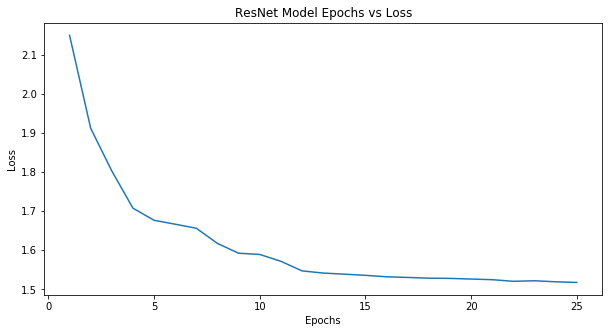

In [0]:
#Here are graphs for Loss vs Epochs and Accuracy vs Epochs

numEpochs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14
             ,15,16,17,18,19,20,21,22,23,24,25,]

plt.figure(figsize=(10,5))

plt.plot(numEpochs, losses)
plt.title('ResNet Model Epochs vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

# plt.legend(names, loc='upper left')
axes = plt.gca()
plt.show()

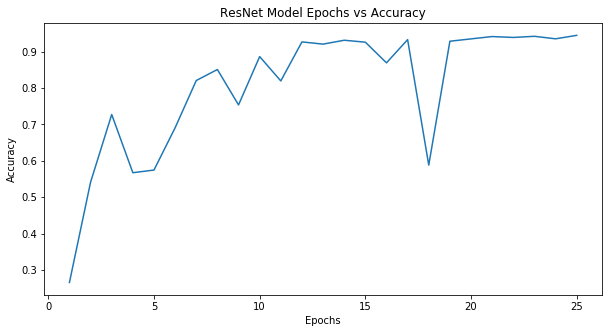

In [0]:
plt.figure(figsize=(10,5))

plt.plot(numEpochs, acc2)
plt.title('ResNet Model Epochs vs Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# plt.legend(names, loc='upper left')
axes = plt.gca()
plt.show()

In [0]:
test_labels = np.empty([test_images.shape[0],])
# indexes = np.arange(0, len(test_labels))


In [0]:
#Evaluate with the test_loader
indexes = []
results = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, data in enumerate(test_loader):
            indexes.append(i)
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            predicted_class = torch.max(outputs, 1)[1]
            results.append(predicted_class.cpu().numpy()[0])

In [0]:
indexes = np.arange(0, len(test_images))
pred_labels = np.asarray(results)

In [0]:
out_df = pd.DataFrame(np.c_[indexes, pred_labels], 
                      columns=['Id', 'Label'])

In [0]:
out_df.to_csv('drive/My Drive/submission3.csv', index=False)
